## Introduction

This notebook demonstrates a sentiment analysis project using two popular natural language processing tools: VADER and TextBlob. The goal is to evaluate their performance on a dataset containing textual reviews and to understand their strengths and weaknesses in classifying sentiments as Positive, Neutral, or Negative.

### Why VADER and TextBlob?
- **VADER (Valence Aware Dictionary and sEntiment Reasoner):** A rule-based model specifically tuned for social media text, known for handling context like "not bad" effectively.
- **TextBlob:** A general-purpose library that offers tools for text processing, including a sentiment analysis component based on pattern matching.

### Dataset Overview
The dataset contains textual reviews with ground truth sentiment labels. These reviews are preprocessed for analysis.


In [1]:
!pip install vaderSentiment 
!pip install textblob 
!pip install nltk

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached charset_normalizer-3.4.1-cp39-cp39-win_amd64.whl (102 kB)
  Using cached certifi-2024.12.14-py3-none-any.whl (164 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)
  Using cached idna-3.10-py3-none-any.whl (70 kB)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)
  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2024.11.6-cp39-cp39-win_amd64.whl (274 kB)
  Using cached click-8.1.8-py3-none-any.whl (98 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [31]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\emrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
# Check if the resource is already downloaded to avoid redundancy
def download_nltk_resources(resources):
    for resource in resources:
        if not nltk.download(resource, quiet=True):
            print(f"Downloading NLTK resource: {resource}")
            nltk.download(resource)
        else:
            print(f"NLTK resource '{resource}' is already downloaded.")

resources_needed = ['stopwords', 'punkt']
download_nltk_resources(resources_needed)

# Set English stop words
stop_words = set(stopwords.words('english'))
print(f"Stop words set to English.")

NLTK resource 'stopwords' is already downloaded.
NLTK resource 'punkt' is already downloaded.
Stop words set to English.


## Data Exploration

| Column    | Description |
| ------------- | ----------|
| Overall | rating|
| verified |  the review is posted by a customer who did buy the product from Amazon and paid a normal price |
| reviewTime |  date where the review is posted |
| reviewerID |  userID |
| asin |  Amazon Standard Identification Number, a unique id for each product |
| reviewerName |  username |
| reviewText |  self-explanatory |
| summary |  short summary of reviewText |
| unixReviewTime |  review time in Unix Timestamp format |
| vote |  votes of the review |
| style |  a dictionary of product's metadata |
| image |  images posted by the reviewer after receiving the product |

In [13]:
data = pd.read_json('Video_Games_5.json', lines=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB
None


In [14]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [15]:
#Check missing values per column
miss_val = data.isnull().sum()
miss_val=miss_val.drop(miss_val[miss_val == 0].index).sort_values(ascending = False)
display(pd.DataFrame({'Missing Values':miss_val, 'Percent':round(miss_val/len(data),2)*100}))

,Missing Values,Percent
image,493943,99.0
vote,389784,78.0
style,208340,42.0
reviewText,158,0.0
summary,109,0.0
reviewerName,76,0.0


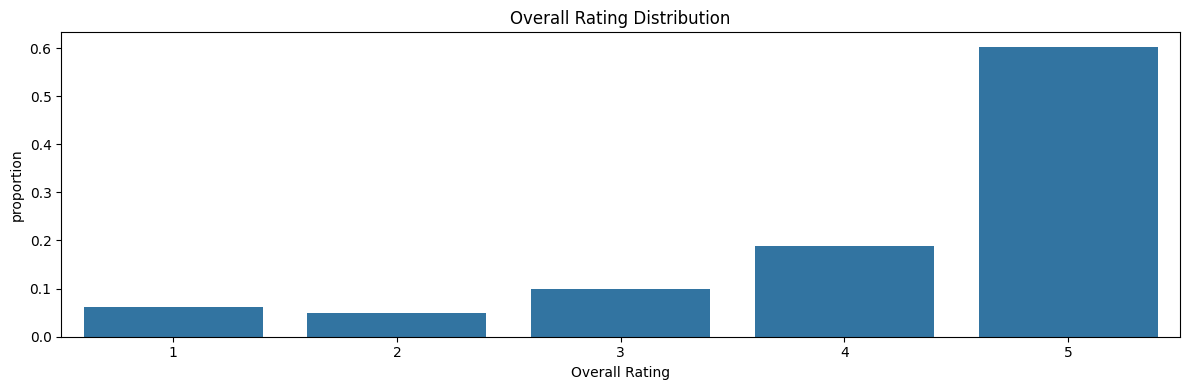

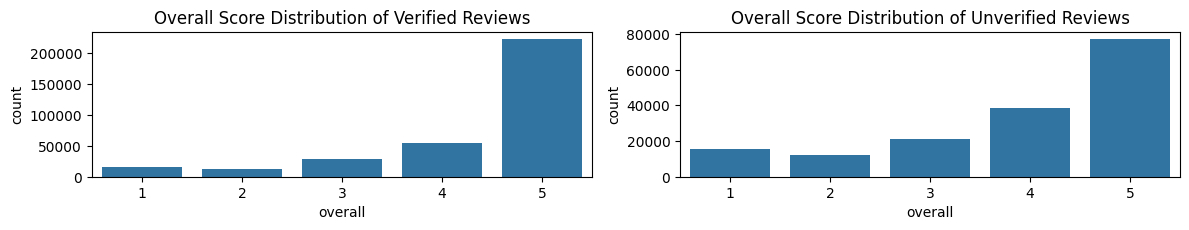

In [21]:
#Plotting the overall rating distribution
rating_counts = data['overall'].value_counts().reset_index()
rating_counts.columns = ['overall', 'count']
rating_counts['proportion'] = rating_counts['count']/rating_counts['count'].sum()

fig = plt.figure(figsize=(12,4))
plt.subplot(1,1,1)
sns.barplot(data=rating_counts,x='overall',y='proportion')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(12,4))
plt.subplot(2,2,1)
sns.barplot(x=data[data['verified']==True]['overall'].value_counts().index,
            y=data[data['verified']==True]['overall'].value_counts() )
plt.title('Overall Score Distribution of Verified Reviews')
plt.subplot(2,2,2)
sns.barplot(x=data[data['verified']==False]['overall'].value_counts().index,
            y=data[data['verified']==False]['overall'].value_counts() )
plt.title('Overall Score Distribution of Unverified Reviews')
plt.tight_layout()
plt.show()

In [22]:
rating_counts = data['overall'].value_counts()
print(f"Rating Counts: \n{rating_counts}\n")

average_rating = data['overall'].mean()
print(f"Average Rating: {average_rating:.2f}")

Rating Counts: 
overall
5    299759
4     93654
3     49146
1     30883
2     24135
Name: count, dtype: int64

Average Rating: 4.22


Distribution of Reviews Across Products: 
asin
B00178630A    1381
B000ZK9QCS     905
B000XJNTNS     834
B00JK00S0S     783
B000ZKA0J6     774
              ... 
B0017YHYFM       1
B000WKW6AU       1
B000XJD33E       1
B000WZ7OD4       1
B0011W8DNW       1
Name: count, Length: 17408, dtype: int64



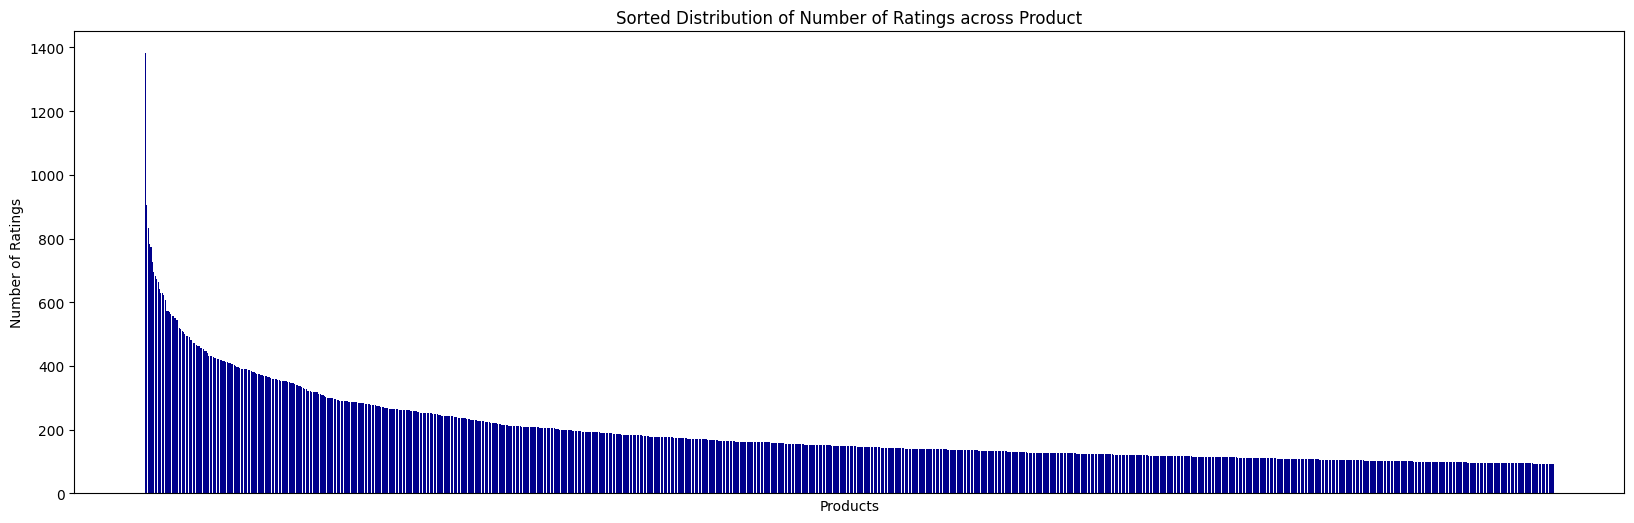

In [24]:
product_review_counts = data['asin'].value_counts()
print(f"Distribution of Reviews Across Products: \n{product_review_counts}\n")

plt.figure(figsize=(20,6))
plt.bar(product_review_counts.index[:1000],product_review_counts[:1000],color='darkblue')
plt.xlabel('Products')
plt.ylabel('Number of Ratings')
plt.title('Sorted Distribution of Number of Ratings across Product')
plt.xticks([])

plt.show()

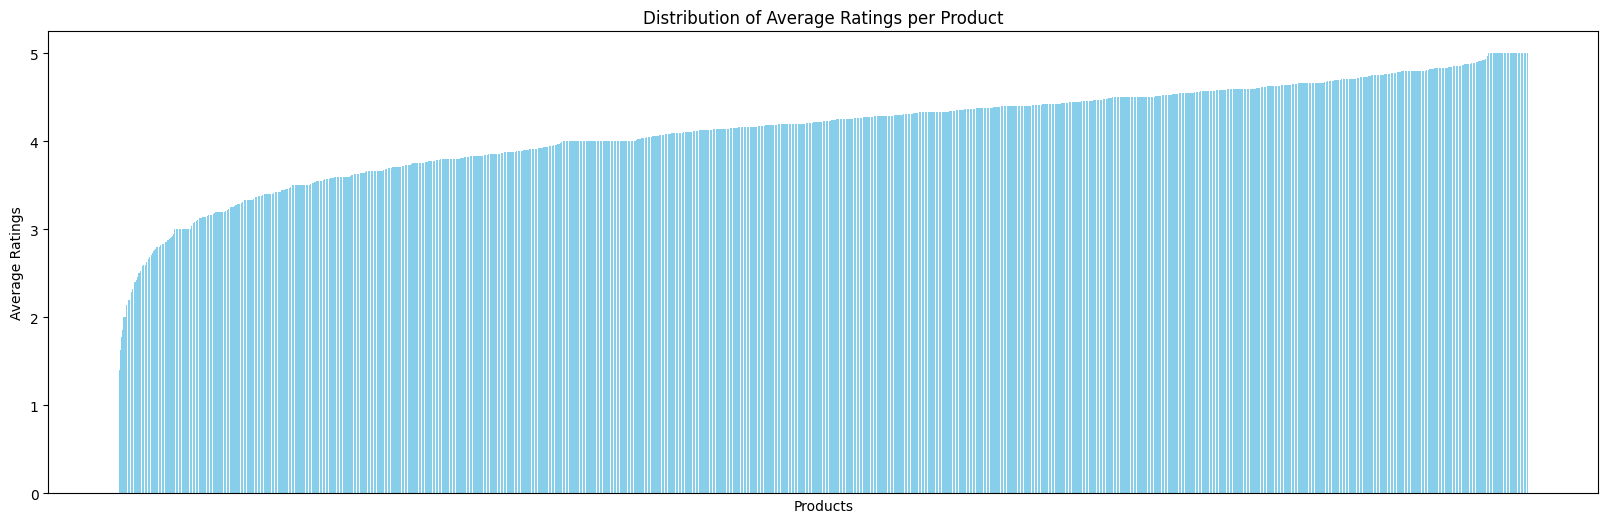

In [25]:
average_ratings_per_product = data.groupby('asin')['overall'].mean().sort_values()

plt.figure(figsize=(20,6))
plt.bar(average_ratings_per_product.index, average_ratings_per_product, color='skyblue')
plt.xlabel('Products')
plt.ylabel('Average Ratings')
plt.title('Distribution of Average Ratings per Product')
plt.xticks([]) 

plt.show()

Distribution of Reviews Per User: 
reviewerID
A3V6Z4RCDGRC44    815
AJKWF4W7QD4NS     795
A3W4D8XOGLWUN5    521
A2QHS1ZCIQOL7E    472
A2TCG2HV1VJP6V    453
                 ... 
A3TJT6OK2CNJQW      5
AP29MC4YEW1NL       5
A28C2PAK06VJ4L      4
A1I75X6T38Y4UW      4
A1HV707K7KWQP0      4
Name: count, Length: 55223, dtype: int64



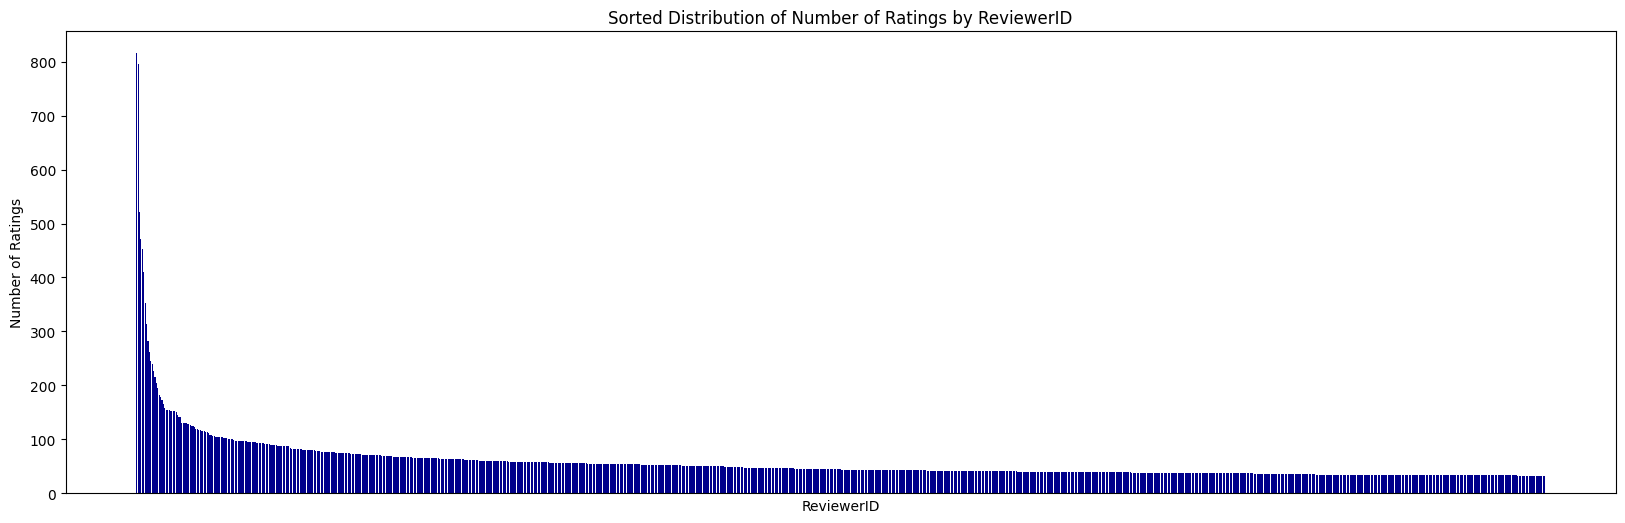

In [26]:
user_review_counts = data['reviewerID'].value_counts()
print(f"Distribution of Reviews Per User: \n{user_review_counts}\n")


plt.figure(figsize=(20,6))
plt.bar(user_review_counts.index[:1000], user_review_counts[:1000], color='darkblue')
plt.xlabel('ReviewerID')
plt.ylabel('Number of Ratings')
plt.title('Sorted Distribution of Number of Ratings by ReviewerID')
plt.xticks([])

plt.show()

In [27]:
#Top20 reviewers' average ratings and number of reviews
top20_reviewer=user_review_counts.head(20).index

for i in top20_reviewer:
  print("reviewerID: ", i)
  print("Average rating: ", data[data['reviewerID']==i].groupby('reviewerID')['overall'].mean().values)
  print("Number of reviews: ", data[data['reviewerID']==i].groupby('reviewerID')['overall'].count().values)
  print()

reviewerID:  A3V6Z4RCDGRC44
Average rating:  [4.29447853]
Number of reviews:  [815]

reviewerID:  AJKWF4W7QD4NS
Average rating:  [3.67672956]
Number of reviews:  [795]

reviewerID:  A3W4D8XOGLWUN5
Average rating:  [3.75815739]
Number of reviews:  [521]

reviewerID:  A2QHS1ZCIQOL7E
Average rating:  [3.66949153]
Number of reviews:  [472]

reviewerID:  A2TCG2HV1VJP6V
Average rating:  [4.0794702]
Number of reviews:  [453]

reviewerID:  A29BQ6B90Y1R5F
Average rating:  [4.20924574]
Number of reviews:  [411]

reviewerID:  A119Q9NFGVOEJZ
Average rating:  [5.]
Number of reviews:  [353]

reviewerID:  A2582KMXLK2P06
Average rating:  [3.55414013]
Number of reviews:  [314]

reviewerID:  A20DZX38KRBIT8
Average rating:  [3.29432624]
Number of reviews:  [282]

reviewerID:  A74TA8X5YQ7NE
Average rating:  [3.70610687]
Number of reviews:  [262]

reviewerID:  A3GKMQFL05Z79K
Average rating:  [4.5755102]
Number of reviews:  [245]

reviewerID:  A1AISPOIIHTHXX
Average rating:  [4.46861925]
Number of reviews: 

In [ ]:
data.dropna(subset=['reviewText'], inplace=True) #Drop reviews without reviewText

def tokenize_rm_stopwords_and_length(review):
    # Tokenize and remove stop words
    tokens = word_tokenize(review)

    filtered_tokens = [word for word in tokens if word not in stop_words]
    ## Join the tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)

    cleaned_tokens = word_tokenize(cleaned_text)
    # The length of the cleaned text in terms of number of words
    length_of_cleaned_text = len(tokens)

    return length_of_cleaned_text,cleaned_text


In [33]:
data['reviewLength'] = data['reviewText'].apply(lambda x: len(x.split()))
data[['cleanedReviewLength', 'cleanedReview']] = data['reviewText'].apply(tokenize_rm_stopwords_and_length).apply(lambda x: pd.Series(x))

In [ ]:
# Basic summary statistics
display(pd.DataFrame(data['reviewLength'].describe()))
display(pd.DataFrame(data['cleanedReviewLength'].describe()))

#records with min len
data[data['reviewLength']==data['reviewLength'].min()]

#records with max len counted by tokenization

#data[data['cleanedReviewLength']==data['cleanedReviewLength'].max()]['reviewText'].values

In [35]:
# Remove unused columns first because the determination of duplicates needs hashable columns
data.drop(columns=['style','image','vote'],inplace=True)
# Remove duplicated rows
data.drop_duplicates(inplace=True)

In [36]:
data['user_and_asin'] = data['reviewerID'] + data['asin']

In [37]:
# Check records with same user and same ASIN
print(data['user_and_asin'].value_counts())

user_and_asin
A14KKV5U5XSHXYB00SN1QEGW    70
A71Z5AIGEFK11B00SN1QEGW     45
A8J2YHESWGF2EB014P7QI6I      6
AZQGB17PI6D3NB014P7QI6I      6
A2HYAYOI8XX1ITB014P7QI6I     6
                            ..
AVECM71LSZLC5B01HGPUTCA      1
A1RS06313BL6WNB01HH6JEOC     1
ACIZ77IGIX2JLB01HH6JEOC      1
A34GG58TJ1A3SHB01HIZF7XE     1
A2GPRA9HHLOC4B0700026398     1
Name: count, Length: 473270, dtype: int64


In [38]:
data[data['user_and_asin']=='A14KKV5U5XSHXYB00SN1QEGW']

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewLength,cleanedReviewLength,cleanedReview,user_and_asin
390179,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,I much prefer this controller over the standar...,Should be the standard remote...,1533168000,34,41,I much prefer controller standard Wii Remote ....,A14KKV5U5XSHXYB00SN1QEGW
390180,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,This controller makes any game that supports i...,This controller makes any game that supports i...,1533168000,29,29,This controller makes game supports much playa...,A14KKV5U5XSHXYB00SN1QEGW
390181,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Feels great in your hands and works very well....,Excellent!,1533168000,27,30,Feels great hands works well . It familiar des...,A14KKV5U5XSHXYB00SN1QEGW
390182,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Bought this for super smash bros. It is a grea...,Does what it's supposed to,1533168000,40,45,Bought super smash bros . It great controller ...,A14KKV5U5XSHXYB00SN1QEGW
390183,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Definitely one of my favorite controllers. Sym...,Five Stars,1533168000,67,77,Definitely one favorite controllers . Symmetri...,A14KKV5U5XSHXYB00SN1QEGW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390244,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,am so used to having the 2nd analog stick belo...,They ahd the best thing going with the gamecub...,1533168000,48,51,used 2nd analog stick buttons I could get used...,A14KKV5U5XSHXYB00SN1QEGW
390245,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,"Really pleased with this controller, so much n...",Really pleased with this controller,1533168000,47,54,"Really pleased controller , much nicer use gia...",A14KKV5U5XSHXYB00SN1QEGW
493403,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Needed this as an accessory for Wii U as there...,Does the job!,1533168000,16,19,Needed accessory Wii U n't enough controllers ...,A14KKV5U5XSHXYB00SN1QEGW
493404,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,The control is beautiful . Super cmodo y preci...,The best control in the world.,1533168000,27,32,The control beautiful . Super cmodo preciso . ...,A14KKV5U5XSHXYB00SN1QEGW


**EDA Findings**

- Dataset is highly imbalanced, which should be considered during analysis.
- Some of the products receives significantly more reviews than most of the other products
- The average rating for most of the products is above 3
- Some of the users have hundreds of reviews; however, their ratings are not uniform
- There are outlier reviews in terms of their length
- There are reviews for the same product written by the same UserID on the same day and time. There could be system error, but won't affect the sentiment analysis

## Preprocessing

**Steps**

- Creating a variable based on the given score and labeling them as 'Positive' or 'Negative' reviews
- Removing the punctuations
- Identifying the outliers and removing them if necessary

In [39]:
data['label'] = data['overall'].apply(lambda x: 'Positive' if x in (4,5) else ('Negative' if x in (1,2) else 'Neutral'))

In [40]:
data['label'].value_counts()

label
Positive    375486
Negative     51980
Neutral      46558
Name: count, dtype: int64

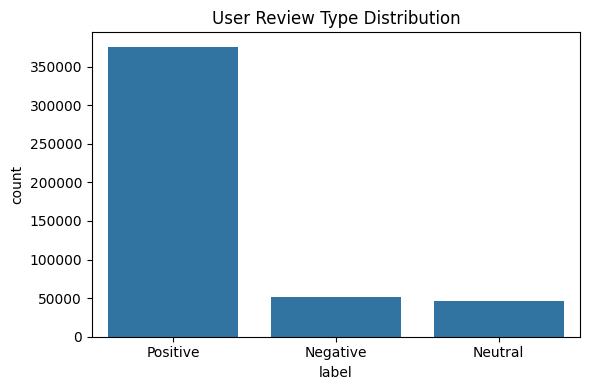

In [41]:
fig = plt.figure(figsize=(6,4))
sns.barplot(x=data['label'].value_counts().index, y=data['label'].value_counts())
plt.title('User Review Type Distribution')
plt.tight_layout()
plt.xlabel('label')
plt.ylabel('count')
plt.show()

In [42]:
def remove_punctuation(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Remove punctuation and lowercase the words
    words_without_punctuations = [word.lower() for word in words if word.isalnum()]

    return words_without_punctuations

### Outlier Detection

Outliers will be identified as reviews that contain no words aligning with the given score. For example, if a review's score suggests a positive sentiment but contains no positive words, it will be flagged as an outlier. Similarly, reviews with negative scores that do not contain any negative words will also be flagged as outliers. To identify these outliers, two external text files will be used to count positive and negative words.

In [43]:
pos_words = pd.read_csv("positive-words.txt", sep="\t",encoding='latin1',header=None)
neg_words = pd.read_csv("negative-words.txt", sep="\t",encoding='latin1',header=None)

pos_words.columns=['words']
neg_words.columns=['words']

pos_set = set(list(pos_words['words']))
neg_set = set(list(neg_words['words']))

In [44]:
def pos_neg_counter(row):
  text = row['reviewText']
  cleaned_words = remove_punctuation(text)
  pos_common_elements=set(cleaned_words)&(pos_set)
  count_pos_common_words = sum(cleaned_words.count(word) for word in pos_common_elements)

  neg_common_elements=set(cleaned_words)&(neg_set)
  count_neg_common_words = sum(cleaned_words.count(word) for word in neg_common_elements)

  return pd.Series({'count_pos_words': count_pos_common_words, 'count_neg_words': count_neg_common_words})

In [45]:
data[['count_pos_words', 'count_neg_words']] = data.apply(pos_neg_counter, axis=1)

In [46]:
data[['count_pos_words', 'count_neg_words']].describe()

,count_pos_words,count_neg_words
count,474024.000000,474024.000000
mean,6.332099,3.589449
std,9.931884,7.952188
min,0.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,1.000000
75%,7.000000,4.000000
max,304.000000,284.000000


In [47]:
#Some samples
data[(data['label']=='Positive')&(data['count_pos_words']==0)]['reviewText'].head(10).values

array(['Dirt 3 on DVD\ni collect racing games so had to add this to my collection\nSon wated one also',
       '<div id="video-block-RQ6P1T4NO5ILD" class="a-section a-spacing-small a-spacing-top-mini video-block"></div><input type="hidden" name="" value="https://images-na.ssl-images-amazon.com/images/I/E1ZmFyi4lRS.mp4" class="video-url"><input type="hidden" name="" value="https://images-na.ssl-images-amazon.com/images/I/11zL7xqwCaS.png" class="video-slate-img-url">&nbsp;Watch it in higher quality here: https://www.youtube.com/watch?v=qHocd4BRRLw\n\nI am giving away a brand new copy of the collector\'s guides of Phantom Hourglass and Spirit Tracks, enter the giveaway here: https://www.youtube.com/watch?v=GqlS5IU2tMw\n\nCheck out the rest of my Zelda collection here: https://www.youtube.com/playlist?list=PLWITUa_LHZlKU0VzGaKKJQSDP104WJf0R',
       'Wish there was more room for future game guides.',
       'A must have for any Zelda fan or collector.',
       "I haven't opened these. I ha

In [48]:
data[(data['label']=='Negative')&(data['count_neg_words']==0)]['reviewText'].head(10).values

array(['This game requires that you open an online account to play the game. A constant online source is required. Gave the game away.',
       "Bought for future investing/collecting. Paper included isn't personally signed by the guy,its just a copy. and this actually dropped in price 40% in the last 9 months since I purchased.",
       "Doesn't work with xbox.",
       "I enjoyed the first Hawx game. However they left out some key things in Hawx 2\n\n1) No coop mode - I really enjoyed that\n2) Can't choose your own plane right off the bat. You have to use whatever they tell you.\n\nThose two things will make me not play this game anymore!",
       "I can't get full range on the analog stick.  I can't find any other adapter except this one on the internet... as though this is the end-all be-all answer we were looking for.",
       "don't really need cards larger than 8MB and the 8MB by sony is most compatible with all games but these work too",
       'Saved one game and now it will n

In [51]:
#Number of reviews will be flagged as 'outlier'
print(f"Number of potential outliers among positive reviews: {len(data[(data['label']=='Positive')&(data['count_pos_words']==0)]['reviewText'])}")
print(f"Number of potential outliers among negative reviews: {len(data[(data['label']=='Negative')&(data['count_neg_words']==0)]['reviewText'])}")

Number of potential outliers among positive reviews: 25504
Number of potential outliers among negative reviews: 7579


In [52]:
outlier_id1 = [data[(data['label']=='Positive')&(data['count_pos_words']==0)].index]
outlier_id2 = [data[(data['label']=='Negative')&(data['count_neg_words']==0)].index]

In [53]:
#Dropping the outlier values
data = data.drop(index=outlier_id1[0].values, axis=0)
data = data.drop(index=outlier_id2[0].values, axis=0)

## Sentiment Analysis

### VADER (Valence Aware Dictionary and Sentiment Reasoner)

**VADER** is optimized for analyzing social media text, including emoticons, acronyms, and slang, requiring minimal pre-processing:

**No Lowercasing Required:** VADER is case-sensitive, distinguishing between uppercase and lowercase for emphasis (e.g., "GOOD" vs. "good").

**Keep Emoticons and Slang:** Since VADER understands emoticons and slang, they should remain unaltered during pre-processing.

**Limited Text Cleaning:** Removing elements like URLs or mentions is useful if they do not contribute to the sentiment analysis, but further cleaning may not be necessary.

**Rationale:** Traditional pre-processing techniques (e.g., stemming, lemmatization, stop-word removal) could reduce VADER's ability to accurately capture sentiment, as it is tailored to social media's unique language patterns.

-----------------------------------------------------

### TextBlob

**TextBlob**'s sentiment analysis follows a more traditional approach and is not specifically designed to handle the nuances of social media text like VADER. Implementing some basic pre-processing steps can enhance its effectiveness:

**Convert to Lowercase:** Ensures uniformity, as TextBlob’s sentiment analyzer doesn’t account for case sensitivity.

**Remove Noise:** Clean the text by removing irrelevant elements such as URLs, HTML tags, and mentions that do not contribute to sentiment analysis.

**Optional Spelling Correction:** TextBlob includes a spell-correction feature that can improve sentiment accuracy by fixing typos. However, this can be resource-intensive and might inadvertently alter the meaning of domain-specific terms or slang.

**Justification:** These pre-processing steps help standardize the text, enabling TextBlob to better analyze the polarity of words and phrases within clean, structured sentences. TextBlob's sentiment analysis relies on well-formed input to deliver accurate results.

**How TextBlob Handles Sentiment Analysis:**

- **Tokenization:** Automatically splits text into words or phrases to analyze the structure.
- **Part-of-Speech Tagging:** Assigns grammatical roles (e.g., nouns, verbs, adjectives) to words, helping contextualize their meaning.
- **Sentiment Analysis:** Evaluates the tokenized and tagged text to calculate polarity (ranging from -1 for very negative to 1 for very positive) and subjectivity (from 0 for objective to 1 for subjective).

In [54]:
def preprocess(text):
    # Check if text is a string
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string inputs

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    return text

data_lexicon = data.copy()

data_lexicon['reviewText_preprocessed'] = data_lexicon['reviewText'].apply(preprocess)
data_lexicon['cleanedReview_preprocessed'] = data_lexicon['cleanedReview'].apply(preprocess)

In [55]:
print(f"Original Review Text: \n{data['reviewText'].head(10)}\n")
print(f"Preprocessed Review Text: \n{data_lexicon['reviewText_preprocessed'].head(10)}\n")
print(f"Without Stopwords Preprocessed Review Text: \n{data_lexicon['cleanedReview_preprocessed'].head(10)}\n")

Original Review Text: 
0    This game is a bit hard to get the hang of, bu...
1    I played it a while but it was alright. The st...
2                                             ok game.
3    found the game a bit too complicated, not what...
4    great game, I love it and have played it since...
5    i liked a lot some time that i haven't play a ...
6    I'm an avid gamer, but Anno 2070 is an INSULT ...
7    I bought this game thinking it would be pretty...
8    I have played the old anno 1701 AND 1503.  thi...
9    I liked it and had fun with it, played for a w...
Name: reviewText, dtype: object

Preprocessed Review Text: 
0    This game is a bit hard to get the hang of, bu...
1    I played it a while but it was alright. The st...
2                                             ok game.
3    found the game a bit too complicated, not what...
4    great game, I love it and have played it since...
5    i liked a lot some time that i haven't play a ...
6    I'm an avid gamer, but Anno 2070

In [58]:
# Randomly select 5000 rows for both data_vader and data_textblob
data_sample = data_lexicon.sample(n=5000, random_state=42)

# Reset the index of the sampled DataFrame
data_sample.reset_index(drop=True, inplace=True)

# Sampling from each category
from sklearn.model_selection import train_test_split
# _, data_sample = train_test_split(data_lexicon,test_size=1000,stratify= data_lexicon['label'] , random_state=42)
_, data_positive = train_test_split(data_lexicon[data_lexicon['label']=='Positive'],test_size=1000,random_state=42)
_, data_negative = train_test_split(data_lexicon[data_lexicon['label']=='Negative'],test_size=1000,random_state=42)
_, data_neutral = train_test_split(data_lexicon[data_lexicon['label']=='Neutral'],test_size=1000,random_state=42)

data_positive.reset_index(drop=True,inplace=True)
data_negative.reset_index(drop=True,inplace=True)
data_neutral.reset_index(drop=True,inplace=True)

In [59]:
print(data_sample['label'].value_counts())
print(data_positive['label'].value_counts())
print(data_negative['label'].value_counts())
print(data_neutral['label'].value_counts())

label
Positive    3964
Neutral      530
Negative     506
Name: count, dtype: int64
label
Positive    1000
Name: count, dtype: int64
label
Negative    1000
Name: count, dtype: int64
label
Neutral    1000
Name: count, dtype: int64


In [60]:
# init for vader
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']  # Return the compound score

def textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Return polarity score



In [61]:
for data in [data_sample,data_positive,data_negative,data_neutral]:
    data['VADER_score'] = data['reviewText_preprocessed'].apply(vader_sentiment)
    data['TextBlob_score'] = data['reviewText_preprocessed'].apply(textblob_sentiment)
    data['VADER_Sentiment'] = data['VADER_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x<= -0.05 else 'Neutral') )
    data['TextBlob_Sentiment'] = data['TextBlob_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x<= -0.05 else 'Neutral') )
    data['VADER_score_cleaned'] = data['cleanedReview_preprocessed'].apply(vader_sentiment)
    data['TextBlob_score_cleaned'] = data['cleanedReview_preprocessed'].apply(textblob_sentiment)
    data['VADER_Sentiment_cleaned'] = data['VADER_score_cleaned'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x<= -0.05 else 'Neutral') )
    data['TextBlob_Sentiment_cleaned'] = data['TextBlob_score_cleaned'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x<= -0.05 else 'Neutral') )

In [62]:
for data in [data_sample,data_positive,data_negative,data_neutral]:
    print('-'*100)
    print(f"VADER Sentiment: \n{data[['reviewText', 'VADER_score','VADER_Sentiment','label']].head()}\n")
    print(f"TextBlob Sentiment: \n{data[['reviewText', 'TextBlob_score', 'TextBlob_Sentiment','label']].head()}\n")
    print(f"VADER Sentiment without stopwords: \n{data[['cleanedReview', 'VADER_score_cleaned','VADER_Sentiment_cleaned','label']].head()}\n")
    print(f"TextBlob Sentiment without stopwords: \n{data[['cleanedReview', 'TextBlob_score_cleaned', 'TextBlob_Sentiment_cleaned','label']].head()}\n")

----------------------------------------------------------------------------------------------------
VADER Sentiment: 
                                          reviewText  VADER_score  \
0  I don't get why everyone was in this huge hiss...       0.5861   
1  First off, I love FPS (first person shooters) ...       0.9732   
2                              Thank you so much :-)       0.6222   
3  This game is awesome! I don't trust IGN, et al...       0.9688   
4  Eternal Sonata is amazing!\n\nThis game was ju...       0.9948   

  VADER_Sentiment     label  
0        Positive  Positive  
1        Positive  Positive  
2        Positive  Positive  
3        Positive  Positive  
4        Positive  Positive  

TextBlob Sentiment: 
                                          reviewText  TextBlob_score  \
0  I don't get why everyone was in this huge hiss...        0.004651   
1  First off, I love FPS (first person shooters) ...        0.108471   
2                              Thank you so much

In [63]:
data_orig_cm = data_sample[['label','VADER_Sentiment','TextBlob_Sentiment']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data_positive_cm = data_positive[['label','VADER_Sentiment','TextBlob_Sentiment']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data_negative_cm = data_negative[['label','VADER_Sentiment','TextBlob_Sentiment']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data_neutral_cm = data_neutral[['label','VADER_Sentiment','TextBlob_Sentiment']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})

data_orig_cm_cleaned = data_sample[['label','VADER_Sentiment_cleaned','TextBlob_Sentiment_cleaned']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data_positive_cm_cleaned = data_positive[['label','VADER_Sentiment_cleaned','TextBlob_Sentiment_cleaned']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data_negative_cm_cleaned = data_negative[['label','VADER_Sentiment_cleaned','TextBlob_Sentiment_cleaned']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data_neutral_cm_cleaned = data_neutral[['label','VADER_Sentiment_cleaned','TextBlob_Sentiment_cleaned']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})

C:\Users\emrey\AppData\Local\Temp\ipykernel_20940\3232873006.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_orig_cm = data_sample[['label','VADER_Sentiment','TextBlob_Sentiment']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
C:\Users\emrey\AppData\Local\Temp\ipykernel_20940\3232873006.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_positive_cm = data_positive[['label','VADER_Sentiment','TextBlob_Sentiment']].replace({'Positive': 1, 'Negative': -1, 'Neutral': 0})
C:\Users\emrey\AppData\Local\Temp\ipyker

### Evaluation Metrics Overview
To evaluate the performance of VADER and TextBlob, we use the following metrics:

- **Precision:** Measures the proportion of correct positive predictions out of all positive predictions.
- **Recall:** Measures the proportion of correct positive predictions out of all actual positives.
- **F1-Score:** A harmonic mean of precision and recall.
- **Accuracy:** The overall correctness of predictions.

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

true_labels = data_orig_cm['label'].values
vader_labels = data_orig_cm['VADER_Sentiment'].values
textblob_labels = data_orig_cm['TextBlob_Sentiment'].values

vader_cm = confusion_matrix(true_labels,vader_labels)
textblob_cm = confusion_matrix(true_labels,textblob_labels)

vader_accuracy = accuracy_score(true_labels,vader_labels)
textblob_accuracy = accuracy_score(true_labels,textblob_labels)


In [83]:
# Overall metrics for VADER
vader_precision, vader_recall, vader_f1, _ = precision_recall_fscore_support(
    true_labels, vader_labels, average='weighted'
)

# Overall metrics for TextBlob
textblob_precision, textblob_recall, textblob_f1, _ = precision_recall_fscore_support(
    true_labels, textblob_labels, average='weighted'
)

In [84]:
metrics = {
    'VADER': {'Precision': vader_precision, 'Recall': vader_recall, 'F1-Score': vader_f1, 'Accuracy': vader_accuracy},
    'TextBlob': {'Precision': textblob_precision, 'Recall': textblob_recall, 'F1-Score': textblob_f1, 'Accuracy': textblob_accuracy}
}
metrics_df = pd.DataFrame(metrics)

In [85]:
metrics_df

,VADER,TextBlob
Precision,0.746341,0.756882
Recall,0.794800,0.707800
F1-Score,0.764614,0.729627
Accuracy,0.794800,0.707800


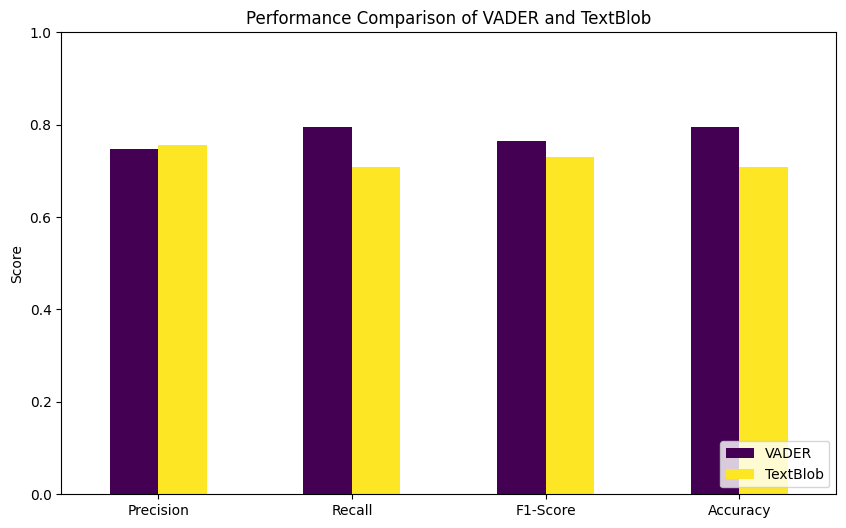

In [86]:
# Plot a bar chart comparing the metrics
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Performance Comparison of VADER and TextBlob')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

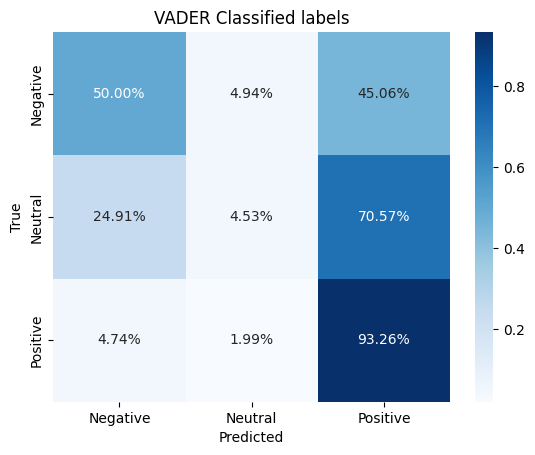

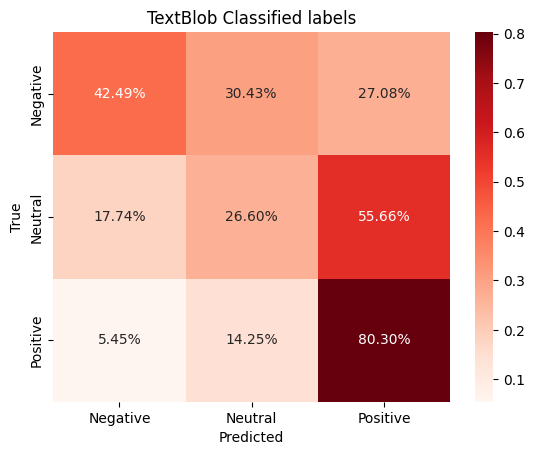

In [73]:
import seaborn as sns

sns.heatmap(vader_cm/vader_cm.sum(axis=1, keepdims=True),annot=True,fmt=".2%", cmap='Blues',xticklabels=["Negative","Neutral","Positive"], yticklabels= ["Negative","Neutral","Positive"])
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("VADER Classified labels")
plt.show()
sns.heatmap(textblob_cm/textblob_cm.sum(axis=1, keepdims=True),annot=True, fmt=".2%", cmap='Reds',xticklabels=["Negative","Neutral","Positive"], yticklabels= ["Negative","Neutral","Positive"])
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("TextBlob Classified labels")
plt.show()

#### General Observations

**VADER Strengths:**
- Higher recall and F1-Score, suggesting it captures more true positives and has a better balance of precision and recall.
- Higher accuracy, making it the more reliable model for general use.

**TextBlob Strengths:**
- Slightly higher precision, meaning it is better at avoiding false positives. It might be preferred if false positives have a higher cost in your application.

## Error Analysis
### Misclassifications
Analyzing specific cases where predictions failed can highlight model biases. Below are a few examples:


In [89]:
data_sample.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewLength,...,reviewText_preprocessed,cleanedReview_preprocessed,VADER_score,TextBlob_score,VADER_Sentiment,TextBlob_Sentiment,VADER_score_cleaned,TextBlob_score_cleaned,VADER_Sentiment_cleaned,TextBlob_Sentiment_cleaned
0,4,True,"08 12, 2016",A31RM5QU797HPJ,B00R9NWTQO,Drez,I don't get why everyone was in this huge hiss...,"Hack and slash, pure and simple",1470960000,315,...,I don't get why everyone was in this huge hiss...,I n't get everyone huge hissy fit game first c...,0.5861,0.004651,Positive,Neutral,-0.8994,0.021650,Negative,Neutral
1,5,False,"06 23, 2004",A2YOVAJZF6OR1H,B0000A03CX,Amazon Customer,"First off, I love FPS (first person shooters) ...",GREAT game that doesn't involve killing,1087948800,216,...,"First off, I love FPS (first person shooters) ...","First , I love FPS ( first person shooters ) l...",0.9732,0.108471,Positive,Positive,0.9756,0.095420,Positive,Positive
2,5,True,"04 11, 2017",A16TV1U851VQ14,B00N46SH98,Mohammed AL-Abbasi,Thank you so much :-),Five Stars,1491868800,5,...,Thank you so much :-),Thank much : - ),0.6222,0.350000,Positive,Positive,0.3612,0.350000,Positive,Positive
3,5,False,"11 18, 2013",A1FG8HACGF1R5E,B00BGAA29M,LVNeptune,"This game is awesome! I don't trust IGN, et al...",Great review of a great game!,1384732800,80,...,"This game is awesome! I don't trust IGN, et al...","This game awesome ! I n't trust IGN , et al. ,...",0.9688,0.017262,Positive,Neutral,0.9699,0.017262,Positive,Neutral
4,4,False,"10 20, 2007",A7EWB8UG8UG3F,B000PC4FYK,Carmen De La Cruz,Eternal Sonata is amazing!\n\nThis game was ju...,Eternal Sonata is amazing! Do not miss this game!,1192838400,271,...,Eternal Sonata is amazing!\n\nThis game was ju...,Eternal Sonata amazing ! This game splendid ! ...,0.9948,0.152070,Positive,Positive,0.9936,0.155357,Positive,Positive


In [90]:
# Identify misclassified examples
vader_misclassified = data_sample[(data_sample['label'] != data_sample['VADER_Sentiment_cleaned'])]
textblob_misclassified = data_sample[(data_sample['label'] != data_sample['TextBlob_Sentiment_cleaned'])]

In [92]:
vader_misclassified

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewLength,...,reviewText_preprocessed,cleanedReview_preprocessed,VADER_score,TextBlob_score,VADER_Sentiment,TextBlob_Sentiment,VADER_score_cleaned,TextBlob_score_cleaned,VADER_Sentiment_cleaned,TextBlob_Sentiment_cleaned
0,4,True,"08 12, 2016",A31RM5QU797HPJ,B00R9NWTQO,Drez,I don't get why everyone was in this huge hiss...,"Hack and slash, pure and simple",1470960000,315,...,I don't get why everyone was in this huge hiss...,I n't get everyone huge hissy fit game first c...,0.5861,0.004651,Positive,Neutral,-0.8994,0.021650,Negative,Neutral
7,3,False,"02 18, 2006",A2IH7X72AMFDHM,B000815N6M,britt,I like adventure/puzzle games. Black Mirror b...,"Average game, gets weird",1140220800,57,...,I like adventure/puzzle games. Black Mirror b...,I like adventure/puzzle games . Black Mirror b...,0.3762,-0.150000,Positive,Negative,-0.1812,-0.150000,Negative,Negative
12,3,False,"12 3, 2007",A1A6C5KIOBMQ2P,B000TTFLS8,Ben,"Decent addition to the COD series, I like the ...",Good not Great,1196640000,204,...,"Decent addition to the COD series, I like the ...","Decent addition COD series , I like change mod...",-0.6291,0.025694,Negative,Neutral,0.7176,0.033477,Positive,Neutral
16,1,False,"04 29, 2016",A320YH0JJX0GL7,B0094H8H7I,Dwayne,This thing is a piece of junk. The only thing...,Chinese junk,1461888000,123,...,This thing is a piece of junk. The only thing...,This thing piece junk . The thing paying Genes...,0.7297,0.082895,Positive,Positive,0.7297,0.076786,Positive,Positive
23,2,False,"05 8, 2011",A74TA8X5YQ7NE,B002BS47YE,NeuroSplicer,SONY's PS3 is now 5 years old whereas MICROSOF...,MAXIMUM...CONSOLING!,1304812800,568,...,SONY's PS3 is now 5 years old whereas MICROSOF...,SONY 's PS3 5 years old whereas MICROSOFT 's X...,-0.4715,0.069916,Negative,Positive,0.7542,0.047860,Positive,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,2,True,"12 18, 2015",A3A8DVE31ITGJW,B00YQ1NOPM,machinebreaker,"Sadly, Fallout 4 did not live up to the pre-re...",We have enjoyed playing Fallout 3 and NV together,1450396800,173,...,"Sadly, Fallout 4 did not live up to the pre-re...","Sadly , Fallout 4 live pre-release pedestal wi...",0.0607,-0.128826,Positive,Negative,0.1243,-0.080387,Positive,Negative
4994,4,True,"10 20, 2014",A2KSB2NISGU7OM,B00ENFVJJO,yazfan,Works very well. Much better than the Nyko on...,Best of a bad lot.,1413763200,74,...,Works very well. Much better than the Nyko on...,Works well . Much better Nyko one . I bought r...,-0.7562,0.200278,Negative,Positive,0.0052,0.244792,Neutral,Positive
4996,3,True,"11 17, 2016",AEPW6G2LRS1X2,B00KBZHSV8,scott,the game is fair not great I own 15 through 17...,no bad could be better,1479340800,26,...,the game is fair not great I own 15 through 17...,game fair great I 15 17 15 like stepping stone...,0.5277,0.200000,Positive,Positive,0.8957,0.400000,Positive,Positive
4997,3,True,"12 5, 2012",A18N1CSWPUU3P5,B0000AW9RE,P. Kutschke,This joystick has performed well for me in ter...,Huge!,1354665600,169,...,This joystick has performed well for me in ter...,This joystick performed well terms drivers ( d...,-0.1092,-0.094497,Negative,Negative,-0.1503,-0.090136,Negative,Negative


In [97]:
# Display a few examples for VADER
print("Misclassified by VADER:")
print()
print("Original text")
print(vader_misclassified['reviewText'].head().values)
print("Given score")
print(vader_misclassified['label'].values)
print("VADER prediction")
print(vader_misclassified['VADER_Sentiment_cleaned'].values)


Misclassified by VADER:

Original text
['I don\'t get why everyone was in this huge hissy fit over this game when it first came out. Sure it has nothing to do with the old school game of the same name that absolutely wowed me at the time when I first played it on my PlayStation 2.....which still works to this day.....yeah, that console is a god.  ALL HAIL THE PLAYSTATION 2!!!!!\n\nAhem.....\n\nIs this a perfect game? No. After all it\'s a hack and slash game and those games, while good, are not perfect.  But I don\'t think the game deserved a zero score on some sites.  I take offense of the people that rated this game a score of 2\'s and zero\'s.  I grew up in the era of the Atari 2600 and I know what a zero game looks like and this game isn\'t one of those by a long shot.\n\nThe story is thin and boring just like most hack and slash games.  The entire point of a game is the gameplay. You can have a game where the story is on par with Paradise Lost but if the gameplay is lackluster it 

In [99]:
# Display a few examples for TextBlob
print("Misclassified by TextBlob:")
print()
print("Original text")
print(textblob_misclassified['reviewText'].head().values)
print("Given score")
print(textblob_misclassified['label'].values)
print("Textblob prediction")
print(textblob_misclassified['TextBlob_Sentiment_cleaned'].values)


Misclassified by TextBlob:

Original text
['I don\'t get why everyone was in this huge hissy fit over this game when it first came out. Sure it has nothing to do with the old school game of the same name that absolutely wowed me at the time when I first played it on my PlayStation 2.....which still works to this day.....yeah, that console is a god.  ALL HAIL THE PLAYSTATION 2!!!!!\n\nAhem.....\n\nIs this a perfect game? No. After all it\'s a hack and slash game and those games, while good, are not perfect.  But I don\'t think the game deserved a zero score on some sites.  I take offense of the people that rated this game a score of 2\'s and zero\'s.  I grew up in the era of the Atari 2600 and I know what a zero game looks like and this game isn\'t one of those by a long shot.\n\nThe story is thin and boring just like most hack and slash games.  The entire point of a game is the gameplay. You can have a game where the story is on par with Paradise Lost but if the gameplay is lackluster 

The sample of misclassified texts shows that both models performed well in identifying the sentiment of the reviews. However, while the users' comments were not positive, their scoring tended to reflect more positive sentiments. Therefore, they resulted as 'misclassified' texts.

## Conclusion

**Which Model to Choose?**

If recall is more important (e.g., minimizing false negatives), go with VADER. This could be relevant in applications like spam detection, where missing a spam message is worse than incorrectly marking one as spam.

If precision is more important (e.g., minimizing false positives), consider TextBlob. This could be useful in applications like sentiment analysis for customer feedback, where labeling neutral comments as positive could lead to misinterpretation.

**Overall**, VADER is the better-balanced model based on these metrics.

### Key Findings
- Both VADER and TextBlob are effective at identifying Positive reviews, with VADER showing slightly higher accuracy.
- TextBlob outperforms VADER in identifying Neutral sentiments, though it often mislabels neutral comments as Positive.
- VADER has a marginal edge in predicting Negative sentiments but tends to skew positive overall.

In [100]:
#!pip freeze > requirements.txt